In [1]:
import pandas as pd
import boto3

In [2]:
!pwd

/Users/audrey.lorberfeld/Desktop/ranked-choice-voting/ranked-choice-voting


In [3]:
df = pd.read_csv('../data/final_master.csv')

In [4]:
df.shape

(26714, 11)

In [5]:
df.head()

,round1winnervotes,round2winnervotes,round3winnervotes,round4winnervotes,round5winnervotes,round6winnervotes,round7winnervotes,total_votes_allrounds,num_candidates,noise,spoiled
0,11346,13632,0,0,0,0.0,0.0,24978,3.0,0.020000,1
1,11220,0,0,0,0,0.0,0.0,11220,3.0,0.030000,1
2,6243,10050,0,0,0,0.0,0.0,16293,3.0,0.046667,0
3,5246,5974,6964,8368,10437,13888.0,20829.0,71706,8.0,0.005000,1
4,17535,24995,0,0,0,0.0,0.0,42530,3.0,0.033333,1


In [15]:
df[df.isna().any(axis=1)]

,round1winnervotes,round2winnervotes,round3winnervotes,round4winnervotes,round5winnervotes,round6winnervotes,round7winnervotes,total_votes_allrounds,num_candidates,noise,spoiled
7398,4843,5772,7406,9746,14340,0.0,NaN,42107,6.0,0.021667,1
7399,5805,6292,0,0,0,0.0,NaN,12097,3.0,0.036667,1
7400,6686,10493,0,0,0,0.0,NaN,17179,3.0,0.000000,1
7401,8063,11588,15108,0,0,0.0,NaN,34759,4.0,0.020000,1
7402,3168,3756,4592,6095,9285,0.0,NaN,26896,6.0,0.018333,1
...,...,...,...,...,...,...,...,...,...,...,...
26709,8603,12067,0,0,0,0.0,NaN,20670,3.0,0.016667,1
26710,2962,3429,4105,5114,6856,10260.0,NaN,32726,7.0,0.008571,1
26711,18078,26186,0,0,0,0.0,NaN,44264,3.0,0.043333,1
26712,2776,3592,4688,6703,0,0.0,NaN,17759,5.0,0.016000,0


In [17]:
# Replacing NaNs w/0s:

import numpy as np

df = df.replace(np.nan, 0)

---

In [41]:
X = df.iloc[:, :-1].values

In [58]:
y = df['spoiled'].values

In [59]:
y

array([1, 1, 0, ..., 1, 0, 1])

## LogReg

In [8]:
from sklearn.linear_model import LogisticRegression

In [71]:
clf = LogisticRegression(random_state=0).fit(X, y)

In [72]:
clf

LogisticRegression(random_state=0)

In [73]:
clf.score(X, y)  # score = mean accuracy

0.8605225724339298

## Random Forest

In [61]:
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.20, random_state = 0)


In [70]:
print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)


(21371, 10)
(21371,)
(5343, 10)
(5343,)


In [75]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

In [76]:
# Train the model on training data
rf.fit(train_X, train_y);

In [80]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_X)

# Calculate the absolute errors
errors = abs(predictions - test_y)


In [88]:
# https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

fi = pd.DataFrame({'feature': list(df.iloc[:, :-1].columns),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [89]:
fi

,feature,importance
1,round2winnervotes,0.246345
0,round1winnervotes,0.243044
7,total_votes_allrounds,0.228400
2,round3winnervotes,0.114034
9,noise,0.090784
3,round4winnervotes,0.046584
4,round5winnervotes,0.015027
8,num_candidates,0.008593
5,round6winnervotes,0.005477
6,round7winnervotes,0.001711


In [91]:
n_nodes = []
max_depths = []

for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


Average number of nodes 5520
Average maximum depth 42


In [107]:
rf.score(X, y)  # mean accuracy

0.9691547503181852

In [108]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_y, predictions)
print(conf_mat)

[[  51  725]
 [  99 4468]]


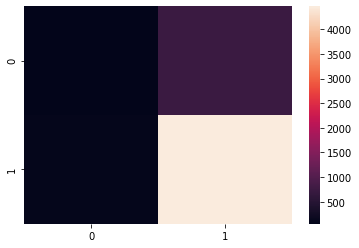

In [111]:
import seaborn
seaborn.heatmap(conf_mat)
plt.show()

[[0.06572165 0.93427835]
 [0.02167725 0.97832275]]


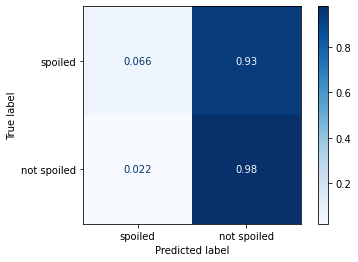

In [114]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

conf_mat = confusion_matrix(test_y, predictions, normalize='true')
print(conf_mat)


disp = plot_confusion_matrix(rf, test_X, test_y,
display_labels=['spoiled', 'not spoiled'], cmap=plt.cm.Blues, normalize='true')

In [123]:
df.spoiled.value_counts()   # 0 = yes, 1 = no

1    22999
0     3715
Name: spoiled, dtype: int64